<a href="https://colab.research.google.com/github/vignu10/parker-demographics/blob/main/metropolis_demographics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parking Demographics

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install python-dotenv pyngrok

# Imports
from dotenv import load_dotenv
import os
from google.colab import files
from google.colab import userdata
from pyngrok import ngrok, conf

# Load environment variables
load_dotenv()

# ngrok token from userdata
authToken = userdata.get("NGROK_AUTHTOKEN")

# Set fixed price file path
price_filename = "/content/drive/MyDrive/parking demo /demographics/TotalCars.csv"

# Ask user to upload the main parking data file
uploaded = files.upload()

# Grab the uploaded filename dynamically
filename = list(uploaded.keys())[0]

# Set ngrok authtoken via pyngrok
conf.get_default().auth_token = authToken

# Confirm everything loaded
print(f"Main parking data file: {filename}")
print(f"Car price data file: {price_filename}")

Saving Updated_Car_Data_with_Models_and_Prices.csv to Updated_Car_Data_with_Models_and_Prices.csv
Main parking data file: Updated_Car_Data_with_Models_and_Prices.csv
Car price data file: /content/drive/MyDrive/parking demo /demographics/TotalCars.csv


In [3]:
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv(filename)
car_prices = pd.read_csv(price_filename)

# Step 1: Deep clean column names
car_prices.columns = car_prices.columns.str.strip().str.replace('\u00a0', '', regex=True).str.title()
df.columns = df.columns.str.strip().str.replace('\u00a0', '', regex=True).str.title()

# Debug check for final column names
print("Cleaned car_prices columns:", car_prices.columns.tolist())
print("Cleaned df columns:", df.columns.tolist())

# Step 2: Standardize Make and Model
def clean_make_model(dataframe):
    dataframe["Make"] = dataframe["Make"].astype(str).str.upper().str.strip()
    dataframe["Model"] = dataframe["Model"].astype(str).str.upper().str.strip()
    return dataframe

df = clean_make_model(df)
car_prices = clean_make_model(car_prices)

# Step 3: Drop duplicates for merge safety
car_prices_unique = car_prices.drop_duplicates(subset=["Make", "Model"])

# Step 4: Merge
df = df.merge(
    car_prices_unique[["Make", "Model"]],
    on=["Make", "Model"],
    how="left"
)
df
# Step 5: Fill missing values
# Final check
# print("✅ Merge complete. Sample:")
# print(df[["Make", "Model", "Price", "Year"]].head())

Cleaned car_prices columns: ['Unnamed: 0', 'Make', 'Model', 'Price']
Cleaned df columns: ['Location', 'Make', 'Model', 'State', 'Entry Time', 'Exit Time', 'Total Amount', 'Validated Amount', 'Plate', 'Price']


,Location,Make,Model,State,Entry Time,Exit Time,Total Amount,Validated Amount,Plate,Price
0,50379,TOYOTA,HIGHLANDER,MD,2025-03-25 13:53:39,2025-03-25 21:35:58,0,0,2DA5624,26310
1,50379,INFINITI,QX50,DC,2025-03-21 10:22:02,2025-03-21 19:53:06,0,0,JH4065,55720
2,50379,CADILLAC,ESCALADE,MD,2025-03-11 10:43:25,2025-03-11 17:38:28,0,0,80764CK,59381
3,92938,NISSAN,SENTRA,NV,2025-03-01 10:42:29,2025-03-01 13:48:01,0,0,428Y96,31588
4,92938,CHEVROLET,EQUINOX,NV,2025-03-01 15:41:16,2025-03-01 16:02:12,0,0,NY816873,27922
...,...,...,...,...,...,...,...,...,...,...
15770,83297,CHEVROLET,TAHOE,NY,2025-03-29 14:57:11,2025-03-30 12:01:00,0,0,LTZ3895,31917
15771,83297,TOYOTA,HIGHLANDER,NY,2025-03-07 20:47:29,2025-03-08 15:29:15,0,0,HER1514,34644
15772,83297,JEEP,UNKNOWN,NY,2025-03-08 23:55:07,2025-03-14 12:22:47,0,0,KMT7502,20055
15773,83297,LINCOLN,UNKNOWN,NY,2025-03-27 11:18:40,2025-03-27 15:47:53,0,0,KKP8494,55361


       Location       Make       Model State           Entry Time  \
0         50379     TOYOTA  HIGHLANDER    MD  2025-03-25 13:53:39   
1         50379   INFINITI        QX50    DC  2025-03-21 10:22:02   
2         50379   CADILLAC    ESCALADE    MD  2025-03-11 10:43:25   
3         92938     NISSAN      SENTRA    NV  2025-03-01 10:42:29   
4         92938  CHEVROLET     EQUINOX    NV  2025-03-01 15:41:16   
...         ...        ...         ...   ...                  ...   
15770     83297  CHEVROLET       TAHOE    NY  2025-03-29 14:57:11   
15771     83297     TOYOTA  HIGHLANDER    NY  2025-03-07 20:47:29   
15772     83297       JEEP     UNKNOWN    NY  2025-03-08 23:55:07   
15773     83297    LINCOLN     UNKNOWN    NY  2025-03-27 11:18:40   
15774     83297      DODGE     UNKNOWN    AL  2025-03-22 12:54:49   

                 Exit Time  Total Amount  Validated Amount     Plate  Price  
0      2025-03-25 21:35:58             0                 0   2DA5624  26310  
1      2025-03-

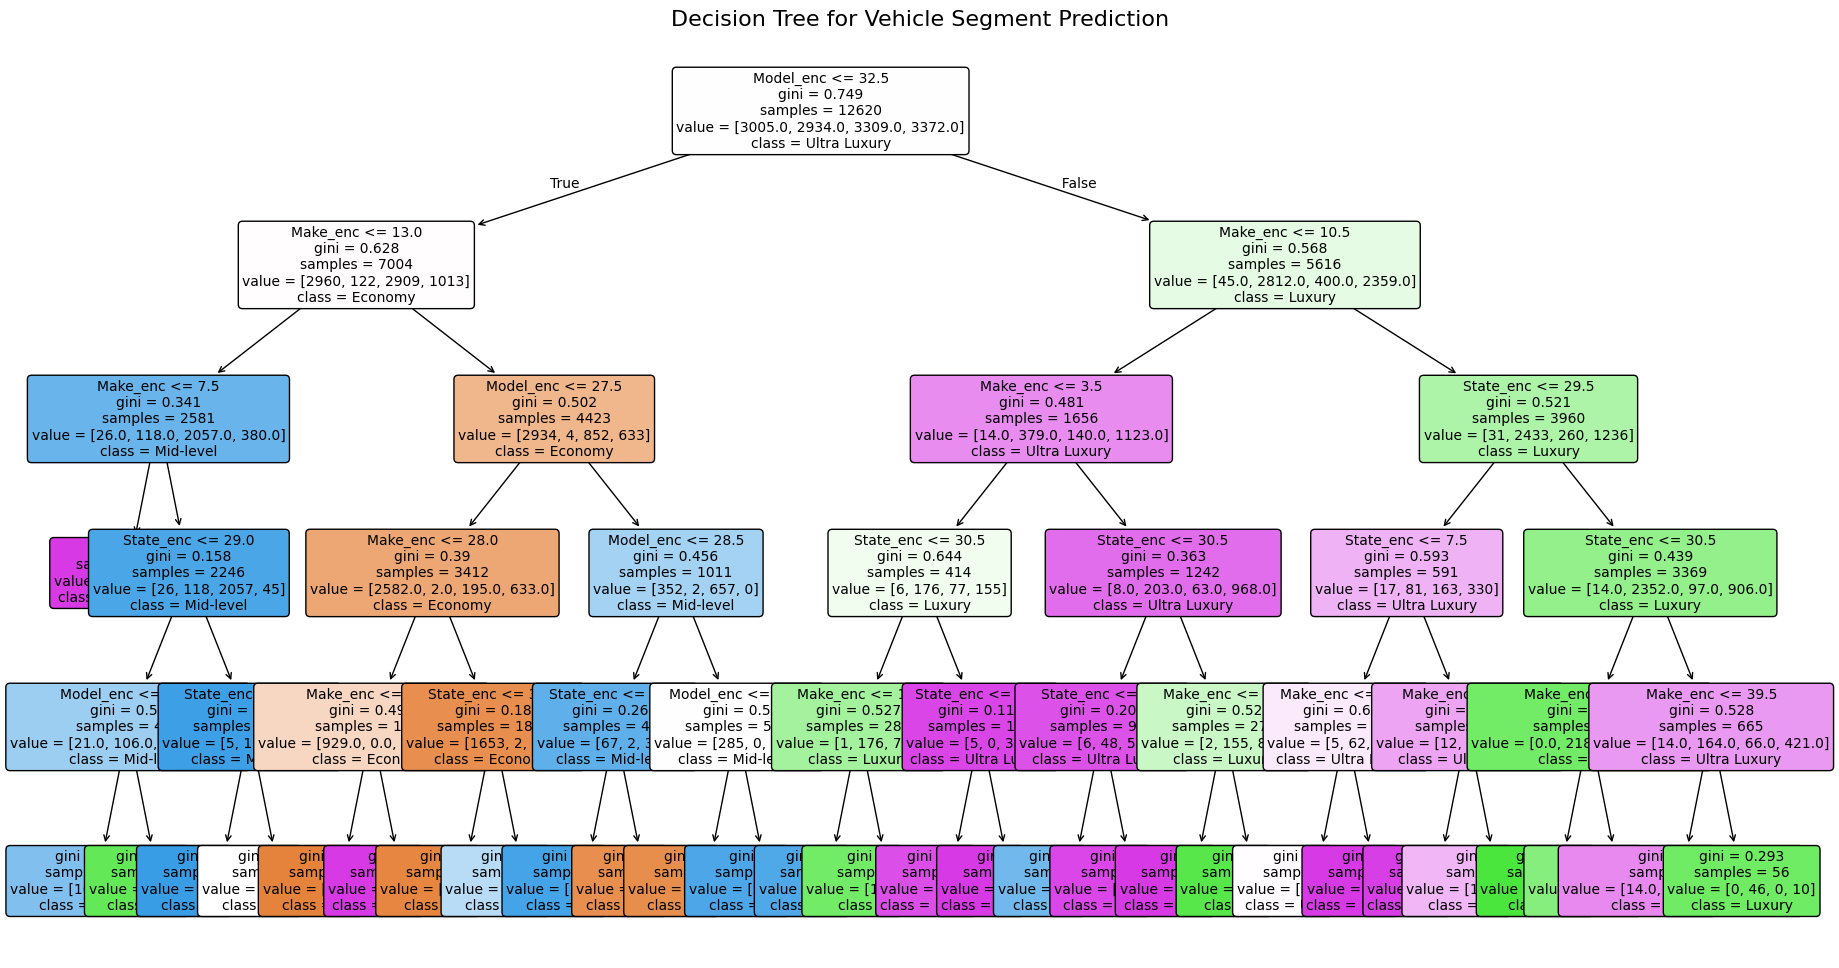

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Load your data
print(df)
def classify_parking_pattern(row):
    entry = pd.to_datetime(row["Entry Time"])
    exit = pd.to_datetime(row["Exit Time"])
    duration = (exit - entry).total_seconds() / 3600
    validated = row["Validated Amount"]

    if duration <= 3:
        return "Short-Term Validated" if validated > 0 else "Short-Term Non-Validated"
    else:
        return "Long-Term Validated" if validated > 0 else "Long-Term Non-Validated"

df["Parking Pattern"] = df.apply(classify_parking_pattern, axis=1)

def classify_time_segment(row):
    hour = pd.to_datetime(row["Entry Time"]).hour
    if 6 <= hour <= 9:
        return "Morning Rush"
    elif 10 <= hour <= 15:
        return "Midday"
    elif 17 <= hour <= 21:
        return "Evening"
    else:
        return "Late Night"

df["Time Segment"] = df.apply(classify_time_segment, axis=1)

# --- Encode Categorical Variables ---
df["Make_enc"] = LabelEncoder().fit_transform(df["Make"].astype(str))
df["Model_enc"] = LabelEncoder().fit_transform(df["Model"].astype(str))
df["State_enc"] = LabelEncoder().fit_transform(df["State"].astype(str))

# ---------------------------
# (A) Predict Price (Regression)
# ---------------------------
X_price = df[["Make_enc", "Model_enc", "State_enc"]]
y_price = df["Price"]
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_price, y_train_price)
df["Estimated Price"] = reg.predict(X_price)

print("Price Prediction R² Score:", reg.score(X_test_price, y_test_price))

# ---------------------------
# Dynamically Label Vehicle Segment (4 Tiers)
# ---------------------------
# Get price percentiles
p25 = df["Estimated Price"].quantile(0.25)
p50 = df["Estimated Price"].quantile(0.50)
p75 = df["Estimated Price"].quantile(0.75)

def dynamic_label_vehicle_segment(p):
    if p >= p75:
        return "Ultra Luxury"
    elif p >= p50:
        return "Luxury"
    elif p >= p25:
        return "Mid-level"
    return "Economy"

df["Vehicle Segment"] = df["Estimated Price"].apply(dynamic_label_vehicle_segment)

# ---------------------------
# (B) Predict Vehicle Segment (Classification)
# ---------------------------
X_seg = df[["Make_enc", "Model_enc", "State_enc"]]
y_seg = df["Vehicle Segment"]
X_train_seg, X_test_seg, y_train_seg, y_test_seg = train_test_split(X_seg, y_seg, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train_seg, y_train_seg)
df["Predicted Segment"] = clf.predict(X_seg)

print("Vehicle Segment Model Accuracy:", clf.score(X_test_seg, y_test_seg))

# ---------------------------
# Save enriched data
# ---------------------------
df.to_csv("enriched_data.csv", index=False)

# ---------------------------
# Plot the Decision Tree
# ---------------------------
class_labels = [str(cls) for cls in clf.classes_]

plt.figure(figsize=(22, 12))
plot_tree(
    clf,
    feature_names=["Make_enc", "Model_enc", "State_enc"],
    class_names=class_labels,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for Vehicle Segment Prediction", fontsize=16)
plt.show()

In [56]:
with open("app.py", "w") as f:
    f.write('''
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

st.set_page_config(page_title="Parked Car Demographics", layout="wide")
st.title("🚗 Parked Car Demographics Dashboard")

# Load enriched data
df = pd.read_csv("enriched_data.csv")

# Sidebar: Filter by Location
st.sidebar.header("🔍 Filter Options")
all_locations = sorted(df["Location"].dropna().unique())
selected_locations = st.sidebar.multiselect("📍 Select One or More Locations", all_locations, default=all_locations[:1])

# Filter Data
filtered_df = df[df["Location"].isin(selected_locations)].copy()

# Add luxury segmentation flag
luxury_brands = ["BMW", "MERCEDES-BENZ", "AUDI", "LEXUS", "CADILLAC", "TESLA", "INFINITI"]
filtered_df["Is Luxury"] = filtered_df["Make"].str.upper().isin(luxury_brands)
filtered_df["Car Tier"] = filtered_df["Predicted Segment"]

# Color palette for locations
color_palette = px.colors.qualitative.Set2
color_map = {loc: color_palette[i % len(color_palette)] for i, loc in enumerate(all_locations)}

if not selected_locations:
    st.warning("Please select at least one location to view the data.")
else:
    # VEHICLE SEGMENT DISTRIBUTION (Overall)
    st.subheader("📊 Overall Vehicle Segment Distribution")
    segment_order = ["Economy", "Mid-level", "Luxury"]

    # Count total vehicles per segment
    grouped = filtered_df["Predicted Segment"].value_counts().rename_axis("Predicted Segment").reset_index(name="Count")
    grouped["Predicted Segment"] = pd.Categorical(grouped["Predicted Segment"], categories=segment_order, ordered=True)

    fig1 = px.bar(
        grouped,
        x="Predicted Segment",
        y="Count",
        category_orders={"Predicted Segment": segment_order},
        color="Predicted Segment",  # Optional: to differentiate bars
        title="Overall Vehicle Segment Distribution"
    )

    st.plotly_chart(fig1, use_container_width=True)

    # HOURLY ENTRY TRAFFIC
    st.subheader("⏱️ Hourly Entry Traffic Volume")
    filtered_df["Entry Time"] = pd.to_datetime(filtered_df["Entry Time"])
    filtered_df["Entry Hour"] = filtered_df["Entry Time"].dt.hour
    hour_range = pd.Series(range(24), name="Entry Hour")
    hourly = filtered_df.groupby(["Entry Hour", "Location"]).size().reset_index(name="Vehicle Count")
    hourly = hourly.merge(hour_range.to_frame(), on="Entry Hour", how="right").fillna(0)

    fig2 = go.Figure()
    for loc in selected_locations:
        data = hourly[hourly["Location"] == loc]
        fig2.add_trace(go.Scatter(
            x=data["Entry Hour"],
            y=data["Vehicle Count"],
            mode="lines+markers",
            name=str(loc),
            line=dict(color=color_map.get(loc)),
            hovertemplate=f"<b>Location:</b> {loc}<br><b>Hour:</b> %{{x}}<br><b>Vehicles:</b> %{{y}}<extra></extra>"
        ))
    fig2.update_layout(title="Hourly Entry Volume by Location", xaxis_title="Hour of Day", yaxis_title="Vehicle Count",
                       xaxis=dict(tickmode="linear", dtick=1, range=[-0.5, 23.5]), legend_title="Location")
    st.plotly_chart(fig2, use_container_width=True)

    # REVENUE ANALYSIS

    # AVERAGE PARKING DURATION BY TIER & VISIT TYPE
    st.subheader("🕒 Avg Parking Duration by Car Tier & Visit Type")
    filtered_df["Exit Time"] = pd.to_datetime(filtered_df["Exit Time"])
    filtered_df["Duration (hrs)"] = (filtered_df["Exit Time"] - filtered_df["Entry Time"]).dt.total_seconds() / 3600
    filtered_df["Visit Type"] = filtered_df["Duration (hrs)"].apply(lambda x: "Short-Term (<4h)" if x < 4 else "Long-Term (≥4h)")

    duration_stats = (
        filtered_df.groupby(["Car Tier", "Visit Type"])
        .agg(Avg_Duration=("Duration (hrs)", "mean"), Vehicle_Count=("Duration (hrs)", "count"))
        .reset_index()
    )

    duration_stats["Car Tier"] = pd.Categorical(duration_stats["Car Tier"], categories=segment_order, ordered=True)

    fig4 = px.bar(duration_stats, x="Car Tier", y="Avg_Duration", color="Visit Type", barmode="group",
                 category_orders={"Car Tier": segment_order},
                 title="Average Parking Duration by Car Tier and Visit Type",
                 hover_data={"Avg_Duration": ":.2f", "Vehicle_Count": True})
    fig4.update_layout(xaxis_title="Car Tier", yaxis_title="Average Duration (hrs)")
    st.plotly_chart(fig4, use_container_width=True)

    # VISIT FREQUENCY BY CAR TIER
    st.subheader("🔁 Visit Frequency by Car Tier")
    repeat_df = filtered_df.groupby(["Plate", "Location", "Car Tier"]).size().reset_index(name="Visit Count")

    def categorize_visit(n):
        return "1 Visit" if n == 1 else "2 Visits" if n == 2 else "3+ Visits"

    repeat_df["Visit Frequency"] = repeat_df["Visit Count"].apply(categorize_visit)

    repeat_summary = (
        repeat_df.groupby(["Car Tier", "Visit Frequency", "Location"])
        .size().reset_index(name="Vehicle Count")
    )

    visit_order = ["1 Visit", "2 Visits", "3+ Visits"]
    repeat_summary["Car Tier"] = pd.Categorical(repeat_summary["Car Tier"], categories=segment_order, ordered=True)
    repeat_summary["Visit Frequency"] = pd.Categorical(repeat_summary["Visit Frequency"], categories=visit_order, ordered=True)

    fig5 = px.bar(repeat_summary, x="Car Tier", y="Vehicle Count", color="Visit Frequency", barmode="group",
                 category_orders={"Car Tier": segment_order, "Visit Frequency": visit_order},
                 facet_col="Location",
                 title="Repeat Visit Breakdown by Car Tier")
    st.plotly_chart(fig5, use_container_width=True)

    # WEEKDAY vs WEEKEND BY TIER
    st.subheader("📆 Weekday vs Weekend Traffic by Car Tier")
    filtered_df["Day Type"] = filtered_df["Entry Time"].dt.dayofweek.apply(lambda x: "Weekend" if x >= 5 else "Weekday")

    day_group = filtered_df.groupby(["Location", "Car Tier", "Day Type"]).size().reset_index(name="Visit Count")
    day_type_order = ["Weekday", "Weekend"]
    day_group["Car Tier"] = pd.Categorical(day_group["Car Tier"], categories=segment_order, ordered=True)
    day_group["Day Type"] = pd.Categorical(day_group["Day Type"], categories=day_type_order, ordered=True)

    fig6 = px.bar(day_group, x="Car Tier", y="Visit Count", color="Day Type", barmode="group",
                 category_orders={"Car Tier": segment_order, "Day Type": day_type_order},
                 facet_col="Location",
                 title="Weekday vs Weekend Traffic by Car Tier")
    st.plotly_chart(fig6, use_container_width=True)

    # DATA EXPORT
    st.subheader("📋 Filtered Data Table")
    st.dataframe(filtered_df)
    st.download_button("⬇️ Download Filtered Data as CSV", filtered_df.to_csv(index=False), "filtered_data.csv", "text/csv")

''')

In [58]:
# Install dependencies
!pip install -q streamlit pyngrok

# Clean up any existing ngrok processes
import os
os.system("pkill -f ngrok")

# Run Streamlit app in the background
os.system("streamlit run app.py &")

# Start a new ngrok tunnel
from pyngrok import ngrok
public_url = ngrok.connect(8501)

print("🚀 Streamlit App is live at:", public_url)

🚀 Streamlit App is live at: NgrokTunnel: "https://c0a3-35-194-238-125.ngrok-free.app" -> "http://localhost:8501"


# Exploratory Data analysis

In [ ]:
# 🛠️ Step 1: Upload Files
from google.colab import files
uploaded = files.upload()

Saving booking.csv.gz to booking.csv.gz
Saving lprOneMonthData.csv to lprOneMonthData.csv
Saving zone.csv to zone.csv


In [ ]:
# 📦 Step 2: Load Libraries and Read Data
import pandas as pd

# Read the uploaded files
booking_df = pd.read_csv('booking.csv.gz')
lpr_df = pd.read_csv('lprOneMonthData.csv')
zone_df = pd.read_csv('zone.csv')

# 👀 Step 3: Preview Data
print("📘 Booking Data")
display(booking_df.head())

print("🚗 LPR Data")
display(lpr_df.head())

print("📍 Zone Data")
display(zone_df.head())

<ipython-input-36-06330f566746>:5: DtypeWarning: Columns (44,50,60,66,67,85,88,94) have mixed types. Specify dtype option on import or set low_memory=False.
  booking_df = pd.read_csv('booking.csv.gz')


📘 Booking Data


,id,uid,zid,bid,externalbid,bookingState,userType,plateOriginal,vehicleNo,entryPlate,...,accountName,outStandingPaymentBID,OD_Extensions,eventId,p2pEnforcement,country,validationName,hostpassCreatedBy,validatedBy,seriesCategory
0,34576403,0.0,1587,zNa9KetgU7,NaN,8,2.0,J65FKD,J65FK0,J65FKD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34578732,0.0,303,cMYWBeYNqB,NaN,10,2.0,bx,8X,bx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,34599113,NaN,204,NdRqGopqcH,NaN,-99,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34577421,0.0,1566,TQRBVRhvR4,NaN,8,4.0,MYH4393,MYH4393,MYH4393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,34576412,0.0,1587,DUxzjUviEg,NaN,8,2.0,U28MZK,U28M2K,U28MZK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


🚗 LPR Data


,_id,validationStatus,duplicateImages[0].cameraId,duplicateImages[1].cameraId,duplicateImages[0].camTimeEpoch,duplicateImages[1].camTimeEpoch,duplicateImages[0].camTimeText,duplicateImages[1].camTimeText,duplicateImages[0].lprDateTime,duplicateImages[1].lprDateTime,...,voilation_charges.violationFee,voilation_charges.adminFee,duplicateImages[1].openLot,duplicateImages[0].openLot,duplicateImages[1].notes,duplicateImages[0].notes,duplicateImages[1].levenPlate,duplicateImages[0].levenPlate,duplicateImages[0].region.override,entryDuplicateImages[0].region.override
0,67ef87d2855df308a8f33548,Override: Exception,sp-83132-321,NaN,1743725920760,NaN,00:18:40,NaN,2025-04-04 00:18:40,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67ef87cd8d77ab02b66d30a9,Override: Exception,sp-93689-221,NaN,1743736716480,NaN,03:18:36,NaN,2025-04-04 03:18:36,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67ef87b6b3990eb160a3b5f5,NaN,sp-83454-121,NaN,1743736693170,NaN,03:18:13,NaN,2025-04-04 03:18:13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67ef87adb3990eb160a3b5e2,NaN,sp-83089-221,NaN,1743725884160,NaN,00:18:04,NaN,2025-04-04 00:18:04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67ef8790b3990eb160a3b537,NaN,sp-83469-121,NaN,1743725855340,NaN,00:17:35,NaN,2025-04-04 00:17:35,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


📍 Zone Data


,zid,pid,name,short_name,zcode,demoGarage,isGated,createdate,address,lat,...,dailyReport,enableAutomatedReports,report_email_alert_monthly,poc,updated_by,zoneType,transactionType,featureFlags,myspot_poc,additionalDetails
0,1,2,Commerce DEMO,Commerce DEMO,SP0001,0,1,1583475227,"210 Commerce St, Nashville, TN 37201",42.358147,...,NaN,NaN,NaN,NaN,0,NaN,"{""od"": 0, ""p2p"": 0, ""cico"": 1, ""mpos"": 0}",NaN,NaN,"{""hps_cc"": {""MID"": ""650000011264143"", ""PUBLICK..."
1,2,3,SP Garage2,SP Garage2,DI0001,0,1,1583475227,"641 Lewis Wharf, Boston, MA 02110, United States",42.358147,...,NaN,NaN,NaN,NaN,0,NaN,"{""od"": 0, ""p2p"": 0, ""cico"": 1, ""mpos"": 0}",NaN,NaN,"{""hps_cc"": {""MID"": ""650000011264143"", ""PUBLICK..."
2,3,1,Commerce B,Commerce Garage,62276,0,0,1583475227,"210 Commerce St, Nashville, TN 37201",36.163358,...,1.0,1.0,NaN,[],0,NaN,"{""od"": 0, ""p2p"": 1, ""rms"": 1, ""cico"": 1, ""mpos...",NaN,"[{""name"":""TIM BROTZKI"",""contactNumber"":""+16156...","{""hps_cc"": {""MID"": ""650000011264143"", ""PUBLICK..."
3,5,2,Divrt Demo Zone,Divrt01,12346,1,1,1600502221,"483 , Cyber Tower",17.451031,...,NaN,NaN,NaN,NaN,0,NaN,"{""od"": 0, ""p2p"": 0, ""cico"": 1, ""mpos"": 0}",NaN,NaN,"{""hps_cc"": {""MID"": ""650000011264143"", ""PUBLICK..."
4,6,2,DemoGarage2,Demo2,12347,0,1,1600840164,"483 W 145th St, New York",36.163018,...,NaN,NaN,NaN,NaN,0,NaN,"{""od"": 0, ""p2p"": 0, ""cico"": 1, ""mpos"": 0}",NaN,NaN,"{""hps_cc"": {""MID"": ""650000011264143"", ""PUBLICK..."
